In [1]:
import os, sys
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from pathlib import Path

## Compare with data

Three data sources:

- MP measurements with associated MES from ([Constant et al., 2020](#)) via Sébastien Rohais
- Water flux from the site hydrométrique - Y047 4030 : La Têt à Perpignan (Pont-Joffre) (https://www.hydro.eaufrance.fr)
- MES and water flux data given to me by Mel and published in ([Constant et al., 2020](#))

In [2]:
file = '/work/armitagj/runs/caesar-explore/tet/data/mp_fluxes_tet.csv'
df = pd.read_csv(file)
df['datetime'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

In [3]:
file = '/work/armitagj/runs/caesar-explore/tet/data/water-flux-Pont-Joffre-hydroportail.csv'
pont_joffre = pd.read_csv(file)
pont_joffre['datetime'] = pd.to_datetime(pont_joffre['Date (TU)'], format='%Y-%m-%dT%H:%M:%S.000Z')

In [4]:
file = '/work/armitagj/runs/caesar-explore/tet/data/MES.csv'
mes = pd.read_csv(file, delimiter=';', decimal=',')
mes['datetime'] = pd.to_datetime(mes['Date'], format='%d/%m/%y')
file = '/work/armitagj/runs/caesar-explore/tet/data/FMES_wl.csv'
fmes = pd.read_csv(file, decimal=',')
fmes['datetime'] = pd.to_datetime(fmes['Date'], format='%d.%m.%Y')

### Plot data comparison

In [5]:
dfpont = pont_joffre.set_index('datetime', drop=True)
dfpont['Qobs'] = dfpont['Valeur (en m³/s)']
dfpont.drop(columns=['Date (TU)',
                     'Valeur (en m³/s)',
                     'Statut',
                     'Qualification', 
                     'Méthode',
                     'Continuité'], inplace=True)
dfmp = df.set_index('datetime', drop=True)
dfmp['MP'] = dfmp['MP (mg/m3)']
dfmp.drop(columns=['date',
                   'filet',
                   'Q (m3/s)',
                   'MES (g/m3)',
                   'prctgTSM (ppt)',
                   'MP (mg/m3)',
                   'log(MES)',
                   'log(prctgTSM)',
                   'log(Q)'], inplace=True)

df_mp_interp = pd.concat([dfpont, dfmp]).sort_index()
df_mp_interp['Qobs'] = df_mp_interp['Qobs'].interpolate()
df_mp_interp.dropna(inplace=True)

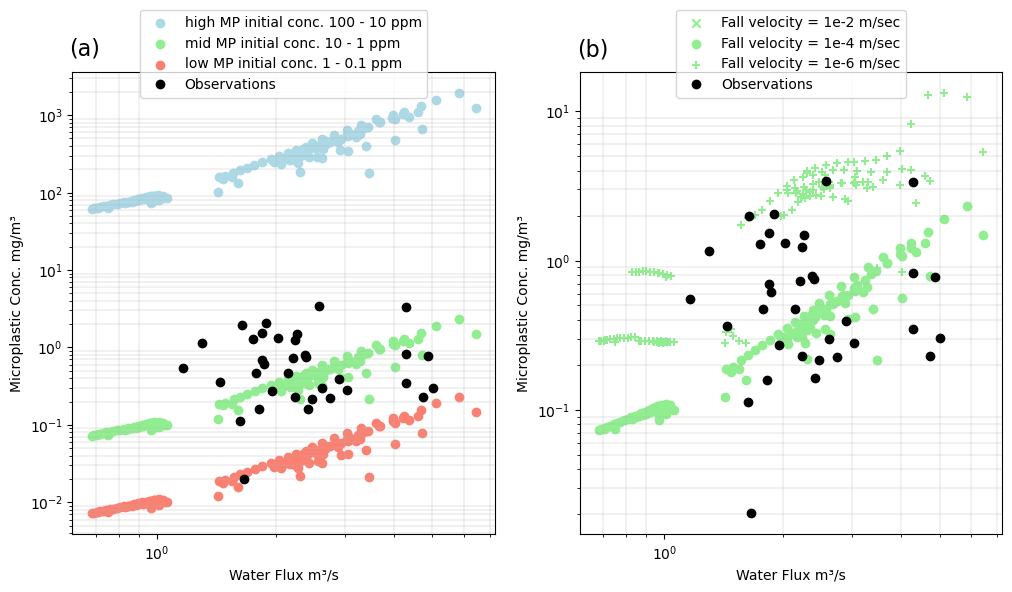

In [6]:
path_to_file = Path('/work/armitagj/runs/caesar-explore/plastics/tet-microplastic-input/')

fig, axs = plt.subplots(1, 2, figsize = [12, 6])
colors = ['lightblue', 'lightgreen', 'salmon']
labels = []

fnames = ['hig', 'mid', 'low']
pconc = ['high', 'mid', 'low']
pend = ['100 - 10 ppm', '10 - 1 ppm', '1 - 0.1 ppm']
res = 200
vdrop = '1e-4'

rain = np.load('../../dem-preprocessing/tet/mean_rainfall_below_vinca.npy')

for ic, fname in enumerate(fnames):

    file = path_to_file/f'{fname}{res}_mp300_r40_v{vdrop}/results/sedoutput.dat'
    
    seds_MPMWplastic = pd.read_csv(file, sep=' ', index_col=False,
                        names=['Time Step',
                               'Qw(actual)', 
                               'Qw(expected)', 
                               'Blank',
                               'Qs',
                               'plastic',
                               'silt', 
                               'very fine sand', 
                               'fine sand',
                               'medium sand',
                               'coarse sand',
                               'granulite',
                               'pebble',
                               'zeros'])
    
    density = 1300
    seds_MPMWplastic['SPC'] = seds_MPMWplastic['plastic'] * density / (seds_MPMWplastic['Qw(actual)'] * 60 * 60 * 24) * 1000 # daily time step for seds
    seds_MPMWplastic['rain'] = np.concatenate((rain, rain[1:]), axis=0)
    s = datetime.datetime.strptime('10/1/2015 12:00:00', '%m/%d/%Y %H:%M:%S') - datetime.timedelta(days=len(rain))
    date_rng = pd.date_range(start=s, periods=len(seds_MPMWplastic), freq='D')
    seds_MPMWplastic['date'] = date_rng[:len(seds_MPMWplastic)]
    seds_all = seds_MPMWplastic.set_index('date', drop=False)
    
    date_start = datetime.datetime.strptime('02/15/2016 12:00:00', '%m/%d/%Y %H:%M:%S')
    date_end = datetime.datetime.strptime('05/01/2016 12:00:00', '%m/%d/%Y %H:%M:%S')
    seds_all_spring = seds_all.loc[date_start:date_end]
    
    date_start = datetime.datetime.strptime('9/01/2016 12:00:00', '%m/%d/%Y %H:%M:%S')
    date_end = datetime.datetime.strptime('11/01/2016 12:00:00', '%m/%d/%Y %H:%M:%S')
    seds_all_autumn = seds_all.loc[date_start:date_end]
    
    seds_all_combi = pd.concat([seds_all_spring, seds_all_autumn])

    axs[0].scatter(seds_all_combi['Qw(actual)'], 1e3 * seds_all_combi['SPC'], marker='o', color=colors[ic])

    labels.append(f'{pconc[ic]} MP initial conc. {pend[ic]}')

axs[0].plot(df_mp_interp['Qobs'], df_mp_interp['MP'], 'ok')
labels.append('Observations')
axs[0].set(xscale="log", yscale="log")
axs[0].xaxis.grid(True, "minor", linewidth=.25)
axs[0].yaxis.grid(True, "minor", linewidth=.25)
axs[0].set_xlabel('Water Flux m³/s')
axs[0].set_ylabel('Microplastic Conc. mg/m³')
axs[0].legend(labels, loc='upper center', bbox_to_anchor=(0.5, 1.15))
axs[0].text(6e-1, 6e3, '(a)', fontsize=16)


colors = ['lightgreen']
markers = ['x', 'o', '+']
labels = []

fname = 'mid'
res = 200
vdrops = ['1e-2', '1e-4', '1e-6']

rain = np.load('../../dem-preprocessing/tet/mean_rainfall_below_vinca.npy')

for ic, vdrop in enumerate(vdrops):

    file = path_to_file/f'{fname}{res}_mp300_r40_v{vdrop}/results/sedoutput.dat'
    
    seds_MPMWplastic = pd.read_csv(file, sep=' ', index_col=False,
                        names=['Time Step',
                               'Qw(actual)', 
                               'Qw(expected)', 
                               'Blank',
                               'Qs',
                               'plastic',
                               'silt', 
                               'very fine sand', 
                               'fine sand',
                               'medium sand',
                               'coarse sand',
                               'granulite',
                               'pebble',
                               'zeros'])
    
    density = 1300
    seds_MPMWplastic['SPC'] = seds_MPMWplastic['plastic'] * density / (seds_MPMWplastic['Qw(actual)'] * 60 * 60 * 24) * 1000 # daily time step for seds
    seds_MPMWplastic['rain'] = np.concatenate((rain, rain[1:]), axis=0)
    s = datetime.datetime.strptime('10/1/2015 12:00:00', '%m/%d/%Y %H:%M:%S') - datetime.timedelta(days=len(rain))
    date_rng = pd.date_range(start=s, periods=len(seds_MPMWplastic), freq='D')
    seds_MPMWplastic['date'] = date_rng[:len(seds_MPMWplastic)]
    seds_all = seds_MPMWplastic.set_index('date', drop=False)
    
    date_start = datetime.datetime.strptime('02/15/2016 12:00:00', '%m/%d/%Y %H:%M:%S')
    date_end = datetime.datetime.strptime('05/01/2016 12:00:00', '%m/%d/%Y %H:%M:%S')
    seds_all_spring = seds_all.loc[date_start:date_end]
    
    date_start = datetime.datetime.strptime('9/01/2016 12:00:00', '%m/%d/%Y %H:%M:%S')
    date_end = datetime.datetime.strptime('11/01/2016 12:00:00', '%m/%d/%Y %H:%M:%S')
    seds_all_autumn = seds_all.loc[date_start:date_end]
    
    seds_all_combi = pd.concat([seds_all_spring, seds_all_autumn])

    axs[1].scatter(seds_all_combi['Qw(actual)'], 1e3 * seds_all_combi['SPC'], marker=markers[ic], color=colors[0])

    labels.append(f'Fall velocity = {vdrop} m/sec')

axs[1].plot(df_mp_interp['Qobs'], df_mp_interp['MP'], 'ok')
labels.append('Observations')
axs[1].set(xscale="log", yscale="log")
axs[1].xaxis.grid(True, "minor", linewidth=.25)
axs[1].yaxis.grid(True, "minor", linewidth=.25)
axs[1].set_xlabel('Water Flux m³/s')
axs[1].set_ylabel('Microplastic Conc. mg/m³')
axs[1].legend(labels, loc='upper center', bbox_to_anchor=(0.5, 1.15))
axs[1].text(6e-1, 2.35e1, '(b)', fontsize=16)

plt.savefig('plots/tet-MP-comp.png', dpi=300)
plt.show()